In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import hdbscan
import seaborn as sns
import statistics
from meegkit import dss
 
from pycrostates.preprocessing import extract_gfp_peaks
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
from eeg_clean import epoch_stats, channel_stats, clean

In [3]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [4]:
def scale(values):
    v = values.reshape(-1, 1)
    scaler = sklearn.preprocessing.StandardScaler()
    noe = scaler.fit_transform(v)
    return noe

In [5]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\Data\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"


raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
raw.crop(60, 120)
raw.set_montage('biosemi64')
#raw.drop_channels(['T8', 'T7', 'F5', 'TP7', 'P9'])

raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=201, verbose=False)

[PCA] Explained variance of selected components : 53.55%
Power of components removed by DSS: 0.09
(61441, 64)
Creating RawArray with float64 data, n_channels=64, n_times=61441
    Range : 0 ... 61440 =      0.000 ...    60.000 secs
Ready.


Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [51]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, 0.5, verbose=False, preload=True)

In [7]:
stats_channels = channel_stats.ChannelStats(ones_epochs, sklearn_scaler=sklearn.preprocessing.MinMaxScaler())

Channel Satbility

At GFP peaks

In [8]:
at_test1 = stats_channels.peak_stab_change
test1 = stats_channels.quasi_stab_change

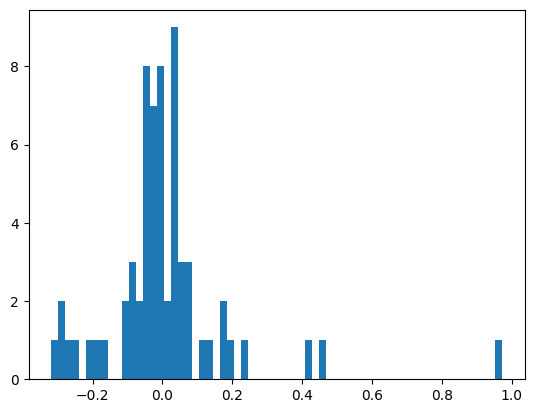

In [9]:
plt.hist(at_test1*64, bins=64)
plt.show()

In [10]:
order = np.argsort(at_test1)
n = 61
print(skew(at_test1[order][:n]))
print(kurtosis(at_test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-0.5618192339914552
0.9032714172541683
['O2' 'Oz' 'O1' 'PO7' 'PO8' 'P7' 'P9' 'Iz' 'POz' 'PO3' 'F4' 'F2' 'PO4'
 'P10' 'C3' 'F1' 'Fz' 'FCz' 'FC3' 'P5' 'P2' 'FC2' 'Pz' 'TP7' 'FC1' 'C2'
 'P8' 'CP3' 'AFz' 'P6' 'CP2' 'P4' 'P1' 'Cz' 'F7' 'F3' 'CPz' 'C1' 'F8'
 'CP5' 'FC4' 'CP6' 'CP4' 'C5' 'AF7' 'TP8' 'P3' 'FT7' 'CP1' 'F6' 'FC5' 'T8'
 'AF4' 'C4' 'F5' 'AF8' 'Fpz' 'FT8' 'FC6' 'C6' 'AF3' 'T7' 'Fp1' 'Fp2']


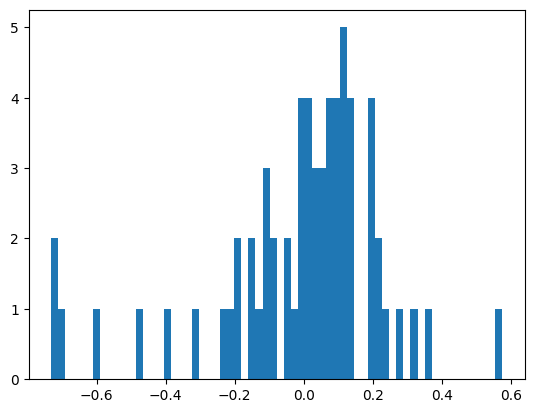

In [11]:
plt.hist(test1*64, bins=64)
plt.show()

In [12]:
order = np.argsort(test1)
n = 64
print(skew(test1[order][:n]))
print(kurtosis(test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-1.132208776313818
1.891750798269337
['Iz' 'O2' 'Oz' 'O1' 'PO7' 'PO8' 'P9' 'F4' 'F2' 'AF4' 'P7' 'AFz' 'PO3'
 'Fz' 'POz' 'C3' 'FC4' 'PO4' 'P5' 'P2' 'P10' 'P4' 'FC2' 'CP5' 'F1' 'CP6'
 'FCz' 'Fpz' 'FC3' 'TP7' 'F6' 'Cz' 'C2' 'F3' 'FC1' 'C1' 'FC6' 'TP8' 'P8'
 'CP3' 'AF3' 'C4' 'P3' 'P6' 'CP2' 'FC5' 'FT7' 'AF8' 'CP4' 'C5' 'Pz' 'F7'
 'C6' 'T8' 'F8' 'CPz' 'P1' 'CP1' 'Fp1' 'AF7' 'F5' 'FT8' 'T7' 'Fp2']


In [13]:
pc_all_chanels = stats_channels.pca_auc_change

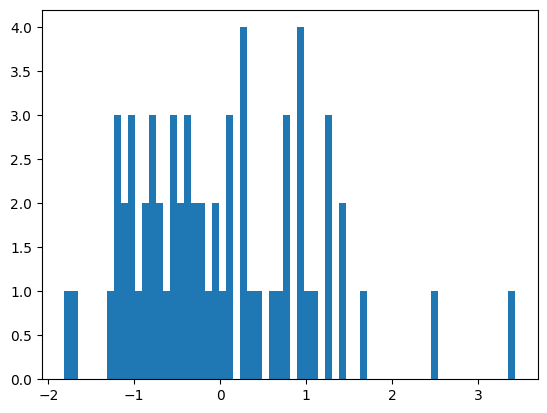

In [14]:
plt.hist(scale(pc_all_chanels), bins=64)
plt.show()

In [15]:
order = np.argsort(pc_all_chanels)
print(stats_channels.ch_name_list[order])

['O1' 'O2' 'F2' 'AFz' 'Iz' 'F4' 'FC2' 'Oz' 'PO7' 'Fz' 'P2' 'POz' 'C2'
 'AF4' 'P7' 'C1' 'Cz' 'FC4' 'FCz' 'F6' 'CP2' 'CPz' 'P1' 'PO4' 'Pz' 'FC5'
 'CP1' 'Fpz' 'P5' 'F8' 'PO3' 'AF8' 'P6' 'PO8' 'CP4' 'FT7' 'F3' 'F1' 'TP8'
 'P8' 'CP5' 'FT8' 'P4' 'FC1' 'F7' 'FC6' 'Fp2' 'C5' 'AF3' 'P3' 'Fp1' 'C6'
 'C4' 'T8' 'AF7' 'P10' 'TP7' 'FC3' 'P9' 'CP6' 'C3' 'F5' 'T7' 'CP3']


In [16]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(stats_channels.ch_name_list[bad_by_corr])

['Fp1' 'AF7' 'F5' 'FC3' 'C3' 'T7' 'TP7' 'CP3' 'P9' 'C4' 'C6' 'T8' 'CP6'
 'P10']


In [17]:
idx = np.where((at_test1 > 0) & (test1 > 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 0  1  5 14 49 50 51 53]


In [18]:
print(stats_channels.ch_name_list[idx])

['Fp1' 'AF7' 'F5' 'T7' 'C4' 'C6' 'T8' 'CP6']


In [19]:
idx = np.where((at_test1 > 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 > 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 0  1  5 14 49 50 51 53]
[ 0  1  5  9 14 15 17 49 50 51 53]


In [20]:
print(stats_channels.ch_name_list[idx])
print(stats_channels.ch_name_list[idx2])

['Fp1' 'AF7' 'F5' 'T7' 'C4' 'C6' 'T8' 'CP6']
['Fp1' 'AF7' 'F5' 'FC3' 'T7' 'TP7' 'CP3' 'C4' 'C6' 'T8' 'CP6']


In [21]:
clean_test = clean.Clean(ones_epochs, sklearn_scaler=sklearn.preprocessing.MinMaxScaler(), quasi=True, peaks=True)

In [22]:
print(stats_channels.ch_name_list[clean_test.bad_channel_index])

['Fp1' 'T7']


In [52]:
ones_epochs.drop_channels(stats_channels.ch_name_list[clean_test.bad_channel_index])
stats = epoch_stats.EpochStats(ones_epochs)
stats.calc_stability()

Number of events,120
Events,1: 120
Time range,0.000 – 0.498 s
Baseline,off


In [24]:
epoched_stability = stats.quasi_stability.get_mean_abs_stab()
convex_stabilty = stats.quasi_stability.get_mean_stab()

Plots to investigate exclusion of epocs not following our assumptions.

Scatter of the two stability types

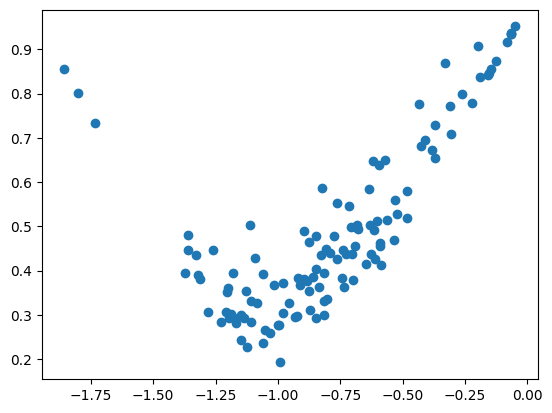

In [25]:
plt.scatter(convex_stabilty-2, epoched_stability)
plt.show()

In [26]:
print(np.where(convex_stabilty-2<-1.5))

(array([82, 83, 84], dtype=int64),)


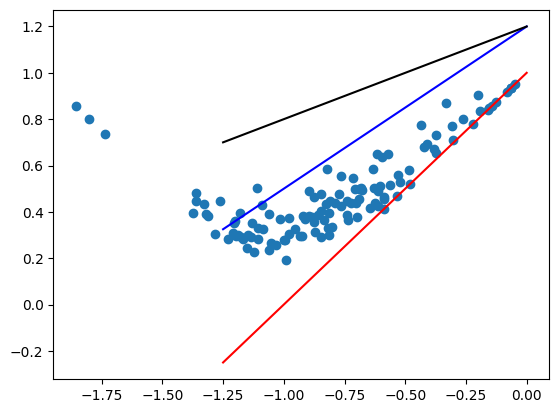

In [27]:
fit = np.poly1d([1, 1])
polyline = np.linspace(-1.25, 0, 100)
reg = np.poly1d([0.7, 1.2])
reg2 = np.poly1d([0.4, 1.2])
plt.scatter(convex_stabilty-2, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()


At GFP peaks

In [28]:
at_epoched_stability = stats.peak_stability.get_mean_abs_stab()
at_convex_stabilty = stats.peak_stability.get_mean_stab()

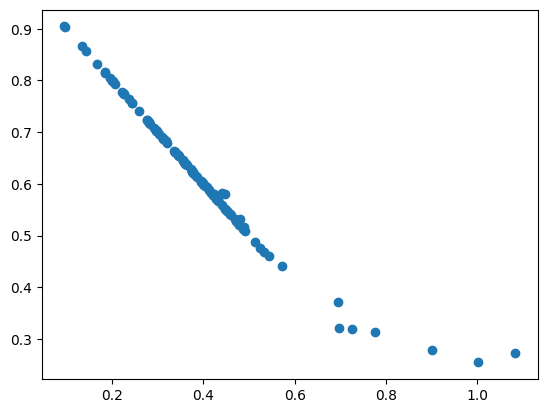

In [29]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

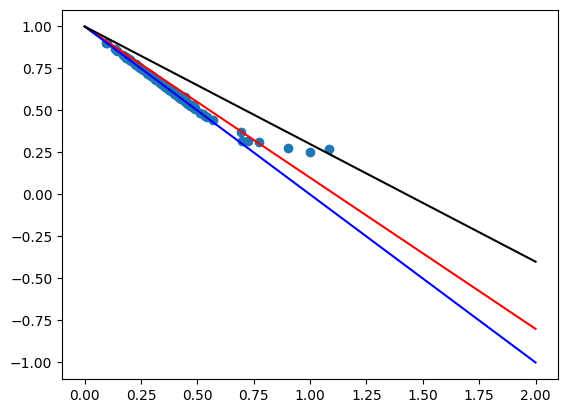

In [30]:
fit = np.poly1d([-0.9, 1])
reg = np.poly1d([-1, 1])
reg2 = np.poly1d([-0.7, 1])
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()

In [31]:
print(fit)

 
-0.9 x + 1


In [32]:
print(clean_test.bad_channel_index)

[ 0 14]


In [70]:
bad_epochs = clean_test.find_bad_epochs(peaks_args={"method": "function_threshold", "function": np.poly1d([-0.1, 1]), "exclude": "bigger"}, quasi_args={"method": "function_threshold", "function": np.poly1d([0.1, 1.2]), "exclude": "bigger"})

In [71]:
print(clean_test.bad_epoch_index)
print(bad_epochs)

None
[None]


Evaluate

In [53]:
from data_quality import ica_score

In [54]:
ones_epochs.drop(clean_test.bad_epoch_index)
ones_epochs.set_eeg_reference()
evaluate = ica_score.IcaScore(ones_epochs)

Dropped 7 epochs: 82, 83, 84, 98, 99, 100, 101
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by number: 16 components
Computing Extended Infomax ICA
Fitting ICA took 5.5s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


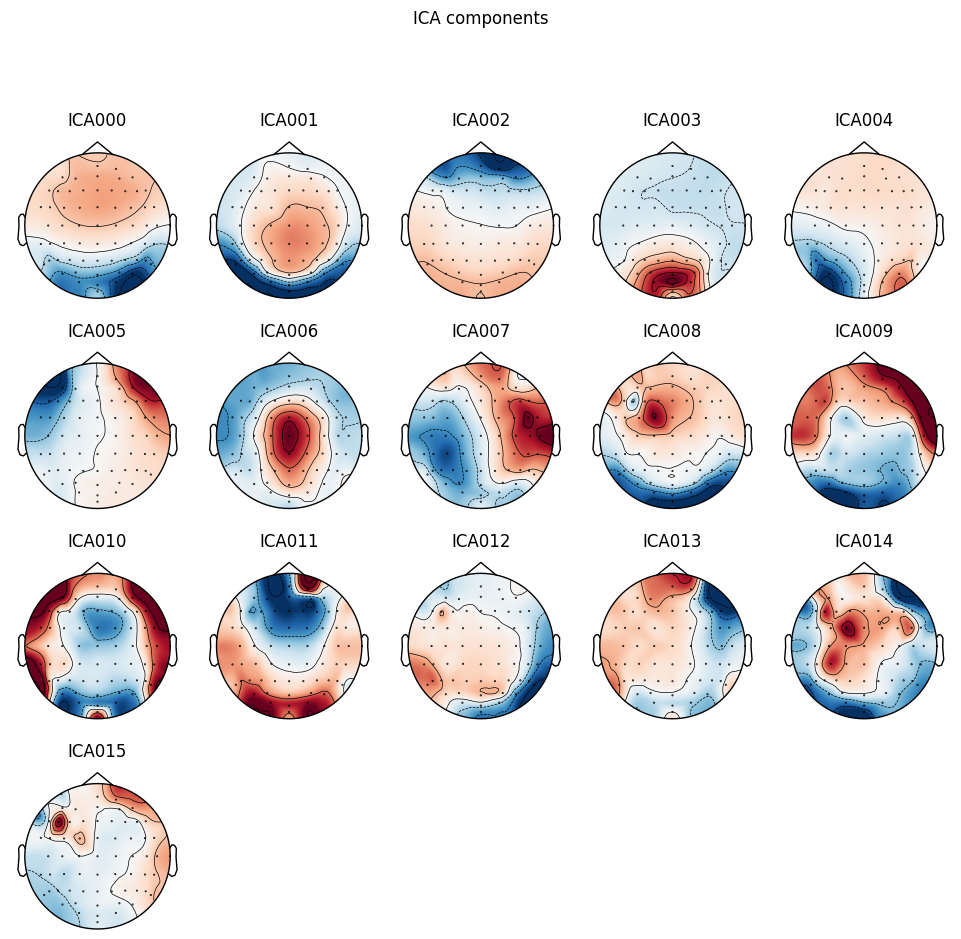

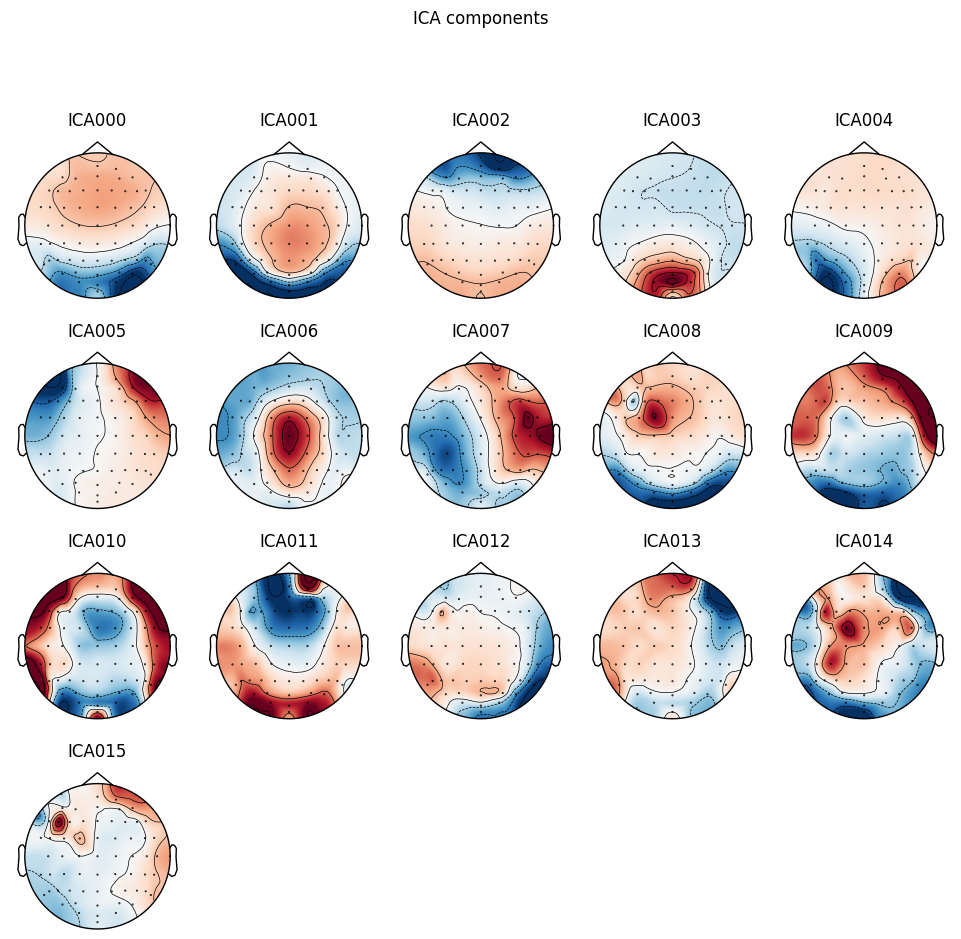

In [55]:
evaluate.ica.plot_components()

In [56]:
print(evaluate.ica_labels)

{'y_pred_proba': array([0.9997113 , 0.9235527 , 0.9806508 , 0.99980104, 0.9960506 ,
       0.99380165, 0.98370034, 0.99964225, 0.9730328 , 0.9322542 ,
       0.9208975 , 0.64803296, 0.98953617, 0.57196814, 0.84102625,
       0.47027194], dtype=float32), 'labels': ['brain', 'brain', 'eye blink', 'brain', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'muscle artifact']}


In [57]:
print(evaluate.get_explained_var(True))

{'eeg': 0.8922248024269012}


In [58]:
print(evaluate.get_explained_var())

{'eeg': 0.7431503721691259}


In [59]:
print(evaluate.get_n_components())

(10, 2)


Did it get better?

In [60]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, 0.5, verbose=False, preload=True)
ones_epochs.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Number of events,120
Events,1: 120
Time range,0.000 – 0.498 s
Baseline,off


In [61]:

evaluate = ica_score.IcaScore(ones_epochs)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 16 components
Computing Extended Infomax ICA
Fitting ICA took 5.1s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


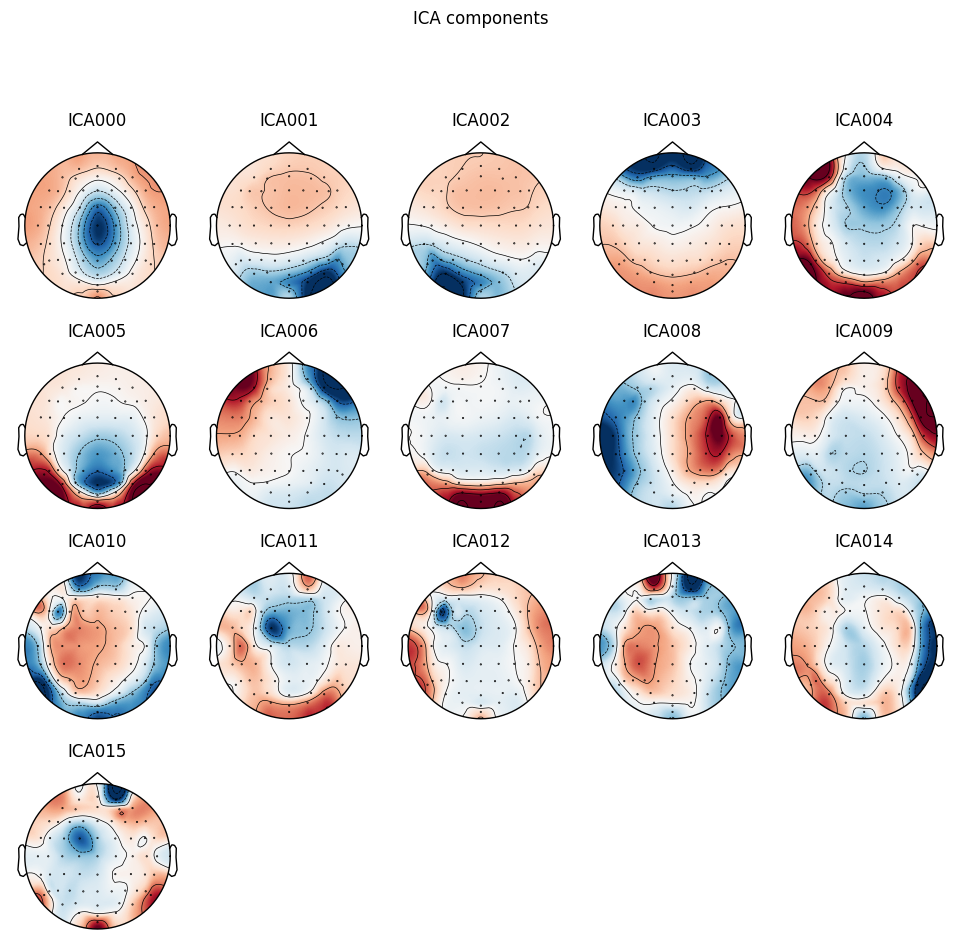

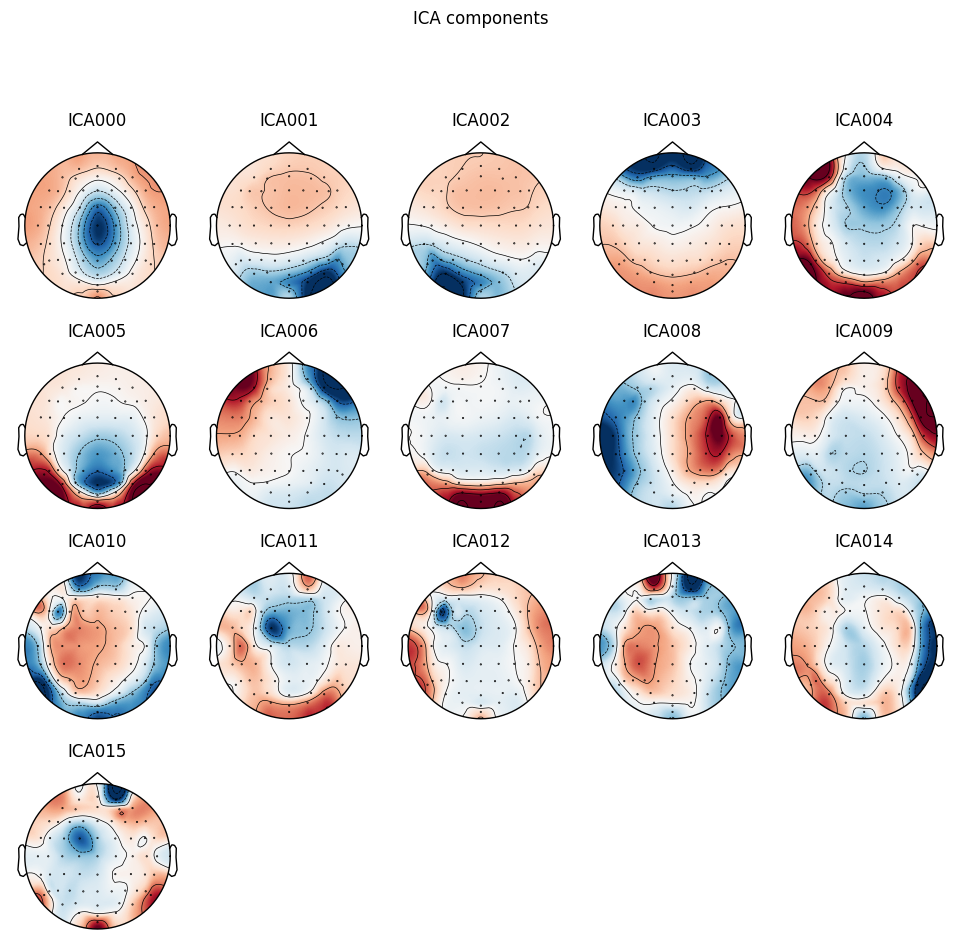

In [62]:
evaluate.ica.plot_components()

In [63]:
print(evaluate.ica_labels)

{'y_pred_proba': array([0.82117546, 0.9996643 , 0.9998742 , 0.51219845, 0.5883786 ,
       0.99794406, 0.95439696, 0.9979399 , 0.99909246, 0.95436585,
       0.9690424 , 0.44008744, 0.9609906 , 0.8210867 , 0.9853561 ,
       0.6598173 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'eye blink', 'muscle artifact', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'muscle artifact']}


In [64]:
print(evaluate.get_explained_var(True))

{'eeg': 0.37571931646562384}


In [65]:
print(evaluate.get_explained_var())

{'eeg': 0.3436823645491335}


In [66]:
print(evaluate.get_n_components())

(9, 1)
